In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import Holt

In [2]:
class KalmanFilter():
    def __init__(self, processNoise, measurementNoise):
        super(KalmanFilter, self).__init__()
        self.processNoise = processNoise # Process noise = 0.0005
        self.measurementNoise = measurementNoise # Measurement noise = 20
        self.estimatedRSSI = 0.0 # calculated rssi
        self.errorCovarianceRSSI = 0.0 # calculated covariance
        self.isInitialized = False # initialization flag

    def applyFilter(self, rssi):
        priorRSSI = 0.0
        kalmanGain = 0.0
        priorErrorCovarianceRSSI = 0.0

        if not self.isInitialized:
            priorRSSI = rssi
            priorErrorCovarianceRSSI = 1
            self.isInitialized = True
        else:
            priorRSSI = self.estimatedRSSI
            priorErrorCovarianceRSSI = self.errorCovarianceRSSI + self.processNoise

        kalmanGain = priorErrorCovarianceRSSI / (priorErrorCovarianceRSSI + self.measurementNoise)
        self.estimatedRSSI = priorRSSI + (kalmanGain * (rssi - priorRSSI))
        self.errorCovarianceRSSI = (1 - kalmanGain) * priorErrorCovarianceRSSI

        return self.estimatedRSSI

In [3]:
class Confidence():
    def __init__(self):
        self.holt_z = 3.219 #2.58

    def holtCheck(self, fcast, se):
        MIN = fcast - ( self.holt_z * se )
        MAX = fcast + ( self.holt_z * se )
        return MIN, MAX

In [4]:
class HoltMethod():
    def __init__(self, level, trend):
        self.level = level
        self.trend = trend

        self.preL = 0
        self.preB = 0

    def holtForcast(self, x):
        
        if self.preL == 0:
            self.preL = x
            self.preB = 0
            return x
        
        l = (self.level * x) + (1 - self.level) * (self.preL + self.preB)
        b = self.trend * (l - self.preL) + (1 - self.trend) * self.preB

        res = l + b

        self.preL = l
        self.preB = b

        return res


In [5]:
class RSSI():
    def __init__(self):
        self.fcast = 0
        self.power_sum = 0
        self.se = 0
        self.idx = 2
        
        self.confi = Confidence()
        self.holt = HoltMethod(level = 0.9, trend = 0.4)
        self.KF = KalmanFilter(processNoise = 0.4, measurementNoise = 5)
        
        self.lower = 0
        self.upper = 0
        self.missC = 0

    def check_RSSI(self, rssi, test):
#         print('===================================================================')
#         print("forecast: ", self.fcast)
        pre_data = self.KF.applyFilter(rssi)
#         print("real: ", pre_data)
#         print('Lower bound: ', self.lower)
#         print('Upper bound: ', self.upper)
        
        if self.lower != 0 and self.upper != 0:
            if test:
#                 print("Miss Counter: ", self.missC)
                if pre_data < self.lower or pre_data > self.upper :
                    return True
                else:
                    return False
            else:
                if pre_data < self.lower or pre_data > self.upper :
                    self.missC += 1
#                     print('Miss!!')
        
    
    
        if self.fcast == 0:     
            self.fcast = self.holt.holtForcast(pre_data)
            return
    
        self.power_sum += np.power(pre_data - self.fcast, 2)

        if self.se == 0:
            self.se = np.sqrt(self.power_sum / ( self.idx - 1 ))
            self.fcast = self.holt.holtForcast(pre_data)
            self.idx += 1
            return
    
        fcast_pre = self.fcast
        se_pre = self.se
    
        self.fcast = self.holt.holtForcast(pre_data)
        self.lower, self.upper = self.confi.holtCheck(self.fcast, self.se)
        self.se = np.sqrt(self.power_sum / ( self.idx - 1))
        self.idx += 1
    
#         print('===================================================================')
        
        return False

In [6]:
res_0cm = []

miss_count_0cm = 0
total_count_0cm = 0

for j in range(1, 1001):
    print("=======================================")
    print("Start: " + str(j))
    df = pd.read_csv('./test_data0/data' + str(j) + '.csv')

    df_rssi = df['RSSI']
    
    RSSI_d = RSSI()
    flag = False
    miss_flag = False
    
    print("Data len: ", len(df_rssi))
    total_count_0cm += len(df_rssi)
    for i in range(len(df_rssi)):
        if i < len(df_rssi) - 1:
            rssi_res = RSSI_d.check_RSSI(df_rssi[i], False)
                
        else:
            rssi_res = RSSI_d.check_RSSI(df_rssi[i], True)
            
            if rssi_res:
                flag = True
                
    miss_count_0cm += RSSI_d.missC
    
    if flag:
        res_0cm.append(True)
    else:
        res_0cm.append(False)
    print("=======================================")

Start: 1
Data len:  2967
Start: 2
Data len:  3307
Start: 3
Data len:  2972
Start: 4
Data len:  3012
Start: 5
Data len:  3377
Start: 6
Data len:  3042
Start: 7
Data len:  3157
Start: 8
Data len:  3187
Start: 9
Data len:  2882
Start: 10
Data len:  3127
Start: 11
Data len:  3067
Start: 12
Data len:  3052
Start: 13
Data len:  2902
Start: 14
Data len:  2957
Start: 15
Data len:  2692
Start: 16
Data len:  3052
Start: 17
Data len:  3112
Start: 18
Data len:  3182
Start: 19
Data len:  2882
Start: 20
Data len:  2987
Start: 21
Data len:  3007
Start: 22
Data len:  2867
Start: 23
Data len:  3207
Start: 24
Data len:  2947
Start: 25
Data len:  3197
Start: 26
Data len:  2982
Start: 27
Data len:  3042
Start: 28
Data len:  2922
Start: 29
Data len:  3267
Start: 30
Data len:  3157
Start: 31
Data len:  2917
Start: 32
Data len:  2912
Start: 33
Data len:  3187
Start: 34
Data len:  2842
Start: 35
Data len:  3197
Start: 36
Data len:  2732
Start: 37
Data len:  2792
Start: 38
Data len:  3212
Start: 39
Data len:  

Start: 80
Data len:  3057
Start: 81
Data len:  2912
Start: 82
Data len:  3217
Start: 83
Data len:  3002
Start: 84
Data len:  2932
Start: 85
Data len:  3082
Start: 86
Data len:  2797
Start: 87
Data len:  3137
Start: 88
Data len:  3027
Start: 89
Data len:  3157
Start: 90
Data len:  3262
Start: 91
Data len:  3147
Start: 92
Data len:  3052
Start: 93
Data len:  3067
Start: 94
Data len:  2847
Start: 95
Data len:  3257
Start: 96
Data len:  2802
Start: 97
Data len:  2897
Start: 98
Data len:  3222
Start: 99
Data len:  3187
Start: 100
Data len:  2882
Start: 101
Data len:  2822
Start: 102
Data len:  2842
Start: 103
Data len:  2952
Start: 104
Data len:  2987
Start: 105
Data len:  2977
Start: 106
Data len:  2872
Start: 107
Data len:  2932
Start: 108
Data len:  2837
Start: 109
Data len:  2957
Start: 110
Data len:  3227
Start: 111
Data len:  3057
Start: 112
Data len:  2977
Start: 113
Data len:  2882
Start: 114
Data len:  3192
Start: 115
Data len:  3237
Start: 116
Data len:  3052
Start: 117
Data len: 

Start: 159
Data len:  3342
Start: 160
Data len:  3237
Start: 161
Data len:  3242
Start: 162
Data len:  3362
Start: 163
Data len:  2962
Start: 164
Data len:  3057
Start: 165
Data len:  2912
Start: 166
Data len:  2712
Start: 167
Data len:  3242
Start: 168
Data len:  3062
Start: 169
Data len:  2932
Start: 170
Data len:  3062
Start: 171
Data len:  2917
Start: 172
Data len:  3047
Start: 173
Data len:  3002
Start: 174
Data len:  3032
Start: 175
Data len:  3037
Start: 176
Data len:  2862
Start: 177
Data len:  2977
Start: 178
Data len:  3017
Start: 179
Data len:  3017
Start: 180
Data len:  3182
Start: 181
Data len:  2932
Start: 182
Data len:  2937
Start: 183
Data len:  3062
Start: 184
Data len:  2927
Start: 185
Data len:  3102
Start: 186
Data len:  3012
Start: 187
Data len:  2992
Start: 188
Data len:  3142
Start: 189
Data len:  2892
Start: 190
Data len:  2877
Start: 191
Data len:  2987
Start: 192
Data len:  2947
Start: 193
Data len:  3167
Start: 194
Data len:  2962
Start: 195
Data len:  3012
S

Start: 237
Data len:  2867
Start: 238
Data len:  3092
Start: 239
Data len:  2912
Start: 240
Data len:  3032
Start: 241
Data len:  3057
Start: 242
Data len:  2922
Start: 243
Data len:  2757
Start: 244
Data len:  2947
Start: 245
Data len:  3027
Start: 246
Data len:  3067
Start: 247
Data len:  3297
Start: 248
Data len:  3007
Start: 249
Data len:  3017
Start: 250
Data len:  3117
Start: 251
Data len:  2947
Start: 252
Data len:  3137
Start: 253
Data len:  3082
Start: 254
Data len:  3102
Start: 255
Data len:  2732
Start: 256
Data len:  2757
Start: 257
Data len:  2962
Start: 258
Data len:  3057
Start: 259
Data len:  2972
Start: 260
Data len:  2927
Start: 261
Data len:  3147
Start: 262
Data len:  3202
Start: 263
Data len:  3152
Start: 264
Data len:  2872
Start: 265
Data len:  2902
Start: 266
Data len:  3047
Start: 267
Data len:  2872
Start: 268
Data len:  2892
Start: 269
Data len:  3067
Start: 270
Data len:  3017
Start: 271
Data len:  2802
Start: 272
Data len:  3157
Start: 273
Data len:  2907
S

Start: 314
Data len:  3192
Start: 315
Data len:  2847
Start: 316
Data len:  3177
Start: 317
Data len:  2872
Start: 318
Data len:  2872
Start: 319
Data len:  2947
Start: 320
Data len:  3222
Start: 321
Data len:  3002
Start: 322
Data len:  3052
Start: 323
Data len:  2887
Start: 324
Data len:  3117
Start: 325
Data len:  3222
Start: 326
Data len:  2832
Start: 327
Data len:  3112
Start: 328
Data len:  2802
Start: 329
Data len:  3222
Start: 330
Data len:  3117
Start: 331
Data len:  2907
Start: 332
Data len:  3127
Start: 333
Data len:  2952
Start: 334
Data len:  3037
Start: 335
Data len:  3082
Start: 336
Data len:  3047
Start: 337
Data len:  2912
Start: 338
Data len:  3167
Start: 339
Data len:  3197
Start: 340
Data len:  3087
Start: 341
Data len:  2882
Start: 342
Data len:  3032
Start: 343
Data len:  3157
Start: 344
Data len:  3127
Start: 345
Data len:  2907
Start: 346
Data len:  3222
Start: 347
Data len:  3027
Start: 348
Data len:  3227
Start: 349
Data len:  2797
Start: 350
Data len:  2912
S

Start: 392
Data len:  2992
Start: 393
Data len:  3062
Start: 394
Data len:  3092
Start: 395
Data len:  2962
Start: 396
Data len:  3017
Start: 397
Data len:  2702
Start: 398
Data len:  3407
Start: 399
Data len:  3167
Start: 400
Data len:  3182
Start: 401
Data len:  2932
Start: 402
Data len:  2867
Start: 403
Data len:  3172
Start: 404
Data len:  2947
Start: 405
Data len:  3147
Start: 406
Data len:  2647
Start: 407
Data len:  2787
Start: 408
Data len:  2997
Start: 409
Data len:  2877
Start: 410
Data len:  3152
Start: 411
Data len:  2812
Start: 412
Data len:  3122
Start: 413
Data len:  2917
Start: 414
Data len:  3152
Start: 415
Data len:  3172
Start: 416
Data len:  3147
Start: 417
Data len:  2817
Start: 418
Data len:  2857
Start: 419
Data len:  2977
Start: 420
Data len:  2657
Start: 421
Data len:  2742
Start: 422
Data len:  2897
Start: 423
Data len:  3017
Start: 424
Data len:  3192
Start: 425
Data len:  3192
Start: 426
Data len:  3017
Start: 427
Data len:  3177
Start: 428
Data len:  3052
S

Data len:  2702
Start: 470
Data len:  3207
Start: 471
Data len:  2802
Start: 472
Data len:  3062
Start: 473
Data len:  2962
Start: 474
Data len:  2987
Start: 475
Data len:  3222
Start: 476
Data len:  2967
Start: 477
Data len:  3082
Start: 478
Data len:  2857
Start: 479
Data len:  2912
Start: 480
Data len:  3032
Start: 481
Data len:  3027
Start: 482
Data len:  3142
Start: 483
Data len:  3187
Start: 484
Data len:  3037
Start: 485
Data len:  3027
Start: 486
Data len:  2872
Start: 487
Data len:  2892
Start: 488
Data len:  2902
Start: 489
Data len:  2957
Start: 490
Data len:  2702
Start: 491
Data len:  2722
Start: 492
Data len:  2782
Start: 493
Data len:  3232
Start: 494
Data len:  2937
Start: 495
Data len:  2912
Start: 496
Data len:  3077
Start: 497
Data len:  3337
Start: 498
Data len:  2967
Start: 499
Data len:  2867
Start: 500
Data len:  3242
Start: 501
Data len:  2997
Start: 502
Data len:  2932
Start: 503
Data len:  2897
Start: 504
Data len:  2797
Start: 505
Data len:  3212
Start: 506
D

Start: 548
Data len:  3002
Start: 549
Data len:  2977
Start: 550
Data len:  2627
Start: 551
Data len:  3002
Start: 552
Data len:  2662
Start: 553
Data len:  3207
Start: 554
Data len:  2917
Start: 555
Data len:  3132
Start: 556
Data len:  2707
Start: 557
Data len:  2987
Start: 558
Data len:  2847
Start: 559
Data len:  3082
Start: 560
Data len:  3122
Start: 561
Data len:  3317
Start: 562
Data len:  3317
Start: 563
Data len:  3132
Start: 564
Data len:  3022
Start: 565
Data len:  2972
Start: 566
Data len:  2767
Start: 567
Data len:  2997
Start: 568
Data len:  3242
Start: 569
Data len:  3177
Start: 570
Data len:  3002
Start: 571
Data len:  2872
Start: 572
Data len:  2992
Start: 573
Data len:  2977
Start: 574
Data len:  3132
Start: 575
Data len:  2682
Start: 576
Data len:  3042
Start: 577
Data len:  3222
Start: 578
Data len:  2942
Start: 579
Data len:  2847
Start: 580
Data len:  3062
Start: 581
Data len:  2832
Start: 582
Data len:  3072
Start: 583
Data len:  2987
Start: 584
Data len:  2952
S

Start: 626
Data len:  3287
Start: 627
Data len:  3152
Start: 628
Data len:  3032
Start: 629
Data len:  2722
Start: 630
Data len:  3017
Start: 631
Data len:  2887
Start: 632
Data len:  2932
Start: 633
Data len:  2762
Start: 634
Data len:  3057
Start: 635
Data len:  3077
Start: 636
Data len:  2887
Start: 637
Data len:  3217
Start: 638
Data len:  3022
Start: 639
Data len:  2987
Start: 640
Data len:  3032
Start: 641
Data len:  3122
Start: 642
Data len:  3117
Start: 643
Data len:  2932
Start: 644
Data len:  3177
Start: 645
Data len:  2932
Start: 646
Data len:  3102
Start: 647
Data len:  2927
Start: 648
Data len:  3087
Start: 649
Data len:  2752
Start: 650
Data len:  2917
Start: 651
Data len:  3187
Start: 652
Data len:  3342
Start: 653
Data len:  3102
Start: 654
Data len:  2952
Start: 655
Data len:  2962
Start: 656
Data len:  3032
Start: 657
Data len:  2927
Start: 658
Data len:  3232
Start: 659
Data len:  2862
Start: 660
Data len:  2852
Start: 661
Data len:  2837
Start: 662
Data len:  2787
S

Data len:  2942
Start: 705
Data len:  2907
Start: 706
Data len:  2997
Start: 707
Data len:  2977
Start: 708
Data len:  3092
Start: 709
Data len:  2782
Start: 710
Data len:  2952
Start: 711
Data len:  3112
Start: 712
Data len:  3187
Start: 713
Data len:  3117
Start: 714
Data len:  2852
Start: 715
Data len:  2887
Start: 716
Data len:  3012
Start: 717
Data len:  3097
Start: 718
Data len:  3102
Start: 719
Data len:  3282
Start: 720
Data len:  2782
Start: 721
Data len:  2857
Start: 722
Data len:  3052
Start: 723
Data len:  3062
Start: 724
Data len:  3137
Start: 725
Data len:  2887
Start: 726
Data len:  2982
Start: 727
Data len:  2852
Start: 728
Data len:  2972
Start: 729
Data len:  3092
Start: 730
Data len:  2657
Start: 731
Data len:  3027
Start: 732
Data len:  2872
Start: 733
Data len:  3062
Start: 734
Data len:  2817
Start: 735
Data len:  3167
Start: 736
Data len:  2937
Start: 737
Data len:  3007
Start: 738
Data len:  2862
Start: 739
Data len:  2712
Start: 740
Data len:  3117
Start: 741
D

Start: 783
Data len:  2987
Start: 784
Data len:  2842
Start: 785
Data len:  2942
Start: 786
Data len:  3012
Start: 787
Data len:  3007
Start: 788
Data len:  2812
Start: 789
Data len:  3337
Start: 790
Data len:  2872
Start: 791
Data len:  2957
Start: 792
Data len:  2947
Start: 793
Data len:  2852
Start: 794
Data len:  2852
Start: 795
Data len:  3072
Start: 796
Data len:  2937
Start: 797
Data len:  2942
Start: 798
Data len:  2817
Start: 799
Data len:  2737
Start: 800
Data len:  3067
Start: 801
Data len:  3207
Start: 802
Data len:  2907
Start: 803
Data len:  2947
Start: 804
Data len:  3252
Start: 805
Data len:  3117
Start: 806
Data len:  2712
Start: 807
Data len:  3057
Start: 808
Data len:  3267
Start: 809
Data len:  3182
Start: 810
Data len:  2862
Start: 811
Data len:  3002
Start: 812
Data len:  3207
Start: 813
Data len:  3042
Start: 814
Data len:  2897
Start: 815
Data len:  2782
Start: 816
Data len:  3252
Start: 817
Data len:  3007
Start: 818
Data len:  3112
Start: 819
Data len:  2767
S

Start: 860
Data len:  3157
Start: 861
Data len:  3032
Start: 862
Data len:  3057
Start: 863
Data len:  2787
Start: 864
Data len:  3322
Start: 865
Data len:  3042
Start: 866
Data len:  3007
Start: 867
Data len:  2822
Start: 868
Data len:  3392
Start: 869
Data len:  3142
Start: 870
Data len:  2912
Start: 871
Data len:  2722
Start: 872
Data len:  2767
Start: 873
Data len:  2912
Start: 874
Data len:  2867
Start: 875
Data len:  3052
Start: 876
Data len:  2872
Start: 877
Data len:  2992
Start: 878
Data len:  2982
Start: 879
Data len:  3097
Start: 880
Data len:  3017
Start: 881
Data len:  3097
Start: 882
Data len:  2742
Start: 883
Data len:  2787
Start: 884
Data len:  2942
Start: 885
Data len:  2977
Start: 886
Data len:  3032
Start: 887
Data len:  3107
Start: 888
Data len:  2962
Start: 889
Data len:  3177
Start: 890
Data len:  2957
Start: 891
Data len:  2837
Start: 892
Data len:  2797
Start: 893
Data len:  3032
Start: 894
Data len:  2822
Start: 895
Data len:  2807
Start: 896
Data len:  2857
S

Start: 939
Data len:  2937
Start: 940
Data len:  3147
Start: 941
Data len:  2967
Start: 942
Data len:  3147
Start: 943
Data len:  3052
Start: 944
Data len:  3027
Start: 945
Data len:  2942
Start: 946
Data len:  2987
Start: 947
Data len:  2817
Start: 948
Data len:  2882
Start: 949
Data len:  3427
Start: 950
Data len:  2887
Start: 951
Data len:  2782
Start: 952
Data len:  2922
Start: 953
Data len:  2847
Start: 954
Data len:  3132
Start: 955
Data len:  2767
Start: 956
Data len:  3072
Start: 957
Data len:  2837
Start: 958
Data len:  3152
Start: 959
Data len:  2922
Start: 960
Data len:  3232
Start: 961
Data len:  3052
Start: 962
Data len:  3032
Start: 963
Data len:  3027
Start: 964
Data len:  2977
Start: 965
Data len:  2857
Start: 966
Data len:  3002
Start: 967
Data len:  2817
Start: 968
Data len:  2817
Start: 969
Data len:  3022
Start: 970
Data len:  3092
Start: 971
Data len:  3072
Start: 972
Data len:  3192
Start: 973
Data len:  2842
Start: 974
Data len:  2817
Start: 975
Data len:  2857
S

In [7]:
res_50cm = []

miss_count_50cm = 0
total_count_50cm = 0

for j in range(1, 1001):
    print("=======================================")
    print("Start: " + str(j))
    df = pd.read_csv('./test_data1/data' + str(j) + '.csv')

    df_rssi = df['RSSI']
    
    RSSI_d = RSSI()
    flag = False
    miss_flag = False
    
    print("Data len: ", len(df_rssi))
    total_count_50cm += len(df_rssi)
    for i in range(len(df_rssi)):
        if i < len(df_rssi) - 1:
            rssi_res = RSSI_d.check_RSSI(df_rssi[i], False)
                
        else:
            rssi_res = RSSI_d.check_RSSI(df_rssi[i], True)
            
            if rssi_res:
                flag = True
                
    miss_count_50cm += RSSI_d.missC
    
    if flag:
        res_50cm.append(True)
    else:
        res_50cm.append(False)
    print("=======================================")

Start: 1
Data len:  3062
Start: 2
Data len:  2992
Start: 3
Data len:  2667
Start: 4
Data len:  3117
Start: 5
Data len:  3282
Start: 6
Data len:  2772
Start: 7
Data len:  2802
Start: 8
Data len:  2882
Start: 9
Data len:  2752
Start: 10
Data len:  3152
Start: 11
Data len:  2867
Start: 12
Data len:  2842
Start: 13
Data len:  2822
Start: 14
Data len:  2692
Start: 15
Data len:  3067
Start: 16
Data len:  3217
Start: 17
Data len:  3052
Start: 18
Data len:  3197
Start: 19
Data len:  3032
Start: 20
Data len:  3207
Start: 21
Data len:  2872
Start: 22
Data len:  2862
Start: 23
Data len:  3117
Start: 24
Data len:  2872
Start: 25
Data len:  2852
Start: 26
Data len:  2997
Start: 27
Data len:  3137
Start: 28
Data len:  2877
Start: 29
Data len:  2942
Start: 30
Data len:  2702
Start: 31
Data len:  3017
Start: 32
Data len:  2967
Start: 33
Data len:  3167
Start: 34
Data len:  3167
Start: 35
Data len:  3182
Start: 36
Data len:  3347
Start: 37
Data len:  3137
Start: 38
Data len:  3047
Start: 39
Data len:  

Start: 81
Data len:  3187
Start: 82
Data len:  3297
Start: 83
Data len:  2997
Start: 84
Data len:  2907
Start: 85
Data len:  2972
Start: 86
Data len:  2907
Start: 87
Data len:  3337
Start: 88
Data len:  2887
Start: 89
Data len:  3112
Start: 90
Data len:  2927
Start: 91
Data len:  2947
Start: 92
Data len:  3147
Start: 93
Data len:  3032
Start: 94
Data len:  2817
Start: 95
Data len:  3192
Start: 96
Data len:  3232
Start: 97
Data len:  2932
Start: 98
Data len:  3027
Start: 99
Data len:  2862
Start: 100
Data len:  3212
Start: 101
Data len:  2902
Start: 102
Data len:  3067
Start: 103
Data len:  2937
Start: 104
Data len:  3272
Start: 105
Data len:  2737
Start: 106
Data len:  3082
Start: 107
Data len:  3102
Start: 108
Data len:  3072
Start: 109
Data len:  2937
Start: 110
Data len:  3127
Start: 111
Data len:  2627
Start: 112
Data len:  3027
Start: 113
Data len:  3032
Start: 114
Data len:  2682
Start: 115
Data len:  3137
Start: 116
Data len:  2942
Start: 117
Data len:  2792
Start: 118
Data len:

Start: 159
Data len:  2787
Start: 160
Data len:  2987
Start: 161
Data len:  3022
Start: 162
Data len:  3082
Start: 163
Data len:  2762
Start: 164
Data len:  2862
Start: 165
Data len:  2957
Start: 166
Data len:  3052
Start: 167
Data len:  2817
Start: 168
Data len:  3082
Start: 169
Data len:  2772
Start: 170
Data len:  3072
Start: 171
Data len:  2927
Start: 172
Data len:  3102
Start: 173
Data len:  2832
Start: 174
Data len:  3067
Start: 175
Data len:  2942
Start: 176
Data len:  3072
Start: 177
Data len:  3047
Start: 178
Data len:  2892
Start: 179
Data len:  2892
Start: 180
Data len:  3152
Start: 181
Data len:  2812
Start: 182
Data len:  2917
Start: 183
Data len:  3137
Start: 184
Data len:  2882
Start: 185
Data len:  3017
Start: 186
Data len:  2932
Start: 187
Data len:  3012
Start: 188
Data len:  3027
Start: 189
Data len:  2522
Start: 190
Data len:  2832
Start: 191
Data len:  2772
Start: 192
Data len:  3137
Start: 193
Data len:  2647
Start: 194
Data len:  2892
Start: 195
Data len:  3062
S

Data len:  3017
Start: 236
Data len:  2862
Start: 237
Data len:  3217
Start: 238
Data len:  3067
Start: 239
Data len:  2922
Start: 240
Data len:  3077
Start: 241
Data len:  3167
Start: 242
Data len:  2997
Start: 243
Data len:  2977
Start: 244
Data len:  2982
Start: 245
Data len:  2977
Start: 246
Data len:  2832
Start: 247
Data len:  2932
Start: 248
Data len:  3172
Start: 249
Data len:  3017
Start: 250
Data len:  3047
Start: 251
Data len:  3052
Start: 252
Data len:  2872
Start: 253
Data len:  3172
Start: 254
Data len:  3002
Start: 255
Data len:  2967
Start: 256
Data len:  3012
Start: 257
Data len:  2937
Start: 258
Data len:  2807
Start: 259
Data len:  3147
Start: 260
Data len:  3442
Start: 261
Data len:  2672
Start: 262
Data len:  3062
Start: 263
Data len:  2987
Start: 264
Data len:  3127
Start: 265
Data len:  3057
Start: 266
Data len:  2977
Start: 267
Data len:  2952
Start: 268
Data len:  3072
Start: 269
Data len:  2967
Start: 270
Data len:  2937
Start: 271
Data len:  3067
Start: 272
D

Data len:  2942
Start: 315
Data len:  3242
Start: 316
Data len:  2922
Start: 317
Data len:  3092
Start: 318
Data len:  2977
Start: 319
Data len:  3187
Start: 320
Data len:  2827
Start: 321
Data len:  3062
Start: 322
Data len:  2907
Start: 323
Data len:  2922
Start: 324
Data len:  2992
Start: 325
Data len:  2787
Start: 326
Data len:  2927
Start: 327
Data len:  3312
Start: 328
Data len:  3187
Start: 329
Data len:  2822
Start: 330
Data len:  3117
Start: 331
Data len:  3042
Start: 332
Data len:  2832
Start: 333
Data len:  2792
Start: 334
Data len:  2852
Start: 335
Data len:  2922
Start: 336
Data len:  3067
Start: 337
Data len:  3062
Start: 338
Data len:  3087
Start: 339
Data len:  3002
Start: 340
Data len:  3007
Start: 341
Data len:  3192
Start: 342
Data len:  2932
Start: 343
Data len:  3022
Start: 344
Data len:  2782
Start: 345
Data len:  3237
Start: 346
Data len:  3062
Start: 347
Data len:  2972
Start: 348
Data len:  2757
Start: 349
Data len:  2977
Start: 350
Data len:  3032
Start: 351
D

Data len:  2922
Start: 394
Data len:  2942
Start: 395
Data len:  3067
Start: 396
Data len:  2757
Start: 397
Data len:  2967
Start: 398
Data len:  3112
Start: 399
Data len:  3087
Start: 400
Data len:  3062
Start: 401
Data len:  2912
Start: 402
Data len:  3077
Start: 403
Data len:  2837
Start: 404
Data len:  3007
Start: 405
Data len:  2932
Start: 406
Data len:  3137
Start: 407
Data len:  3177
Start: 408
Data len:  2977
Start: 409
Data len:  3172
Start: 410
Data len:  3252
Start: 411
Data len:  3052
Start: 412
Data len:  3107
Start: 413
Data len:  3002
Start: 414
Data len:  3072
Start: 415
Data len:  2927
Start: 416
Data len:  3102
Start: 417
Data len:  2847
Start: 418
Data len:  3047
Start: 419
Data len:  3052
Start: 420
Data len:  2877
Start: 421
Data len:  2747
Start: 422
Data len:  2887
Start: 423
Data len:  3107
Start: 424
Data len:  2872
Start: 425
Data len:  2997
Start: 426
Data len:  3027
Start: 427
Data len:  3002
Start: 428
Data len:  2807
Start: 429
Data len:  2962
Start: 430
D

Start: 471
Data len:  2822
Start: 472
Data len:  3002
Start: 473
Data len:  3027
Start: 474
Data len:  3092
Start: 475
Data len:  2867
Start: 476
Data len:  3042
Start: 477
Data len:  2782
Start: 478
Data len:  3162
Start: 479
Data len:  2972
Start: 480
Data len:  2877
Start: 481
Data len:  3272
Start: 482
Data len:  3057
Start: 483
Data len:  3032
Start: 484
Data len:  2767
Start: 485
Data len:  3107
Start: 486
Data len:  2862
Start: 487
Data len:  2767
Start: 488
Data len:  3267
Start: 489
Data len:  3032
Start: 490
Data len:  3022
Start: 491
Data len:  3152
Start: 492
Data len:  3152
Start: 493
Data len:  3112
Start: 494
Data len:  3027
Start: 495
Data len:  2997
Start: 496
Data len:  3057
Start: 497
Data len:  2902
Start: 498
Data len:  3132
Start: 499
Data len:  2742
Start: 500
Data len:  3042
Start: 501
Data len:  2932
Start: 502
Data len:  3022
Start: 503
Data len:  3152
Start: 504
Data len:  2817
Start: 505
Data len:  2782
Start: 506
Data len:  3147
Start: 507
Data len:  3027
S

Start: 550
Data len:  3137
Start: 551
Data len:  3107
Start: 552
Data len:  2817
Start: 553
Data len:  2922
Start: 554
Data len:  3052
Start: 555
Data len:  3362
Start: 556
Data len:  2992
Start: 557
Data len:  3157
Start: 558
Data len:  2767
Start: 559
Data len:  3047
Start: 560
Data len:  3172
Start: 561
Data len:  2837
Start: 562
Data len:  3037
Start: 563
Data len:  2902
Start: 564
Data len:  2987
Start: 565
Data len:  3257
Start: 566
Data len:  2997
Start: 567
Data len:  2962
Start: 568
Data len:  2982
Start: 569
Data len:  2917
Start: 570
Data len:  2832
Start: 571
Data len:  2967
Start: 572
Data len:  3047
Start: 573
Data len:  3037
Start: 574
Data len:  2737
Start: 575
Data len:  3077
Start: 576
Data len:  3092
Start: 577
Data len:  3257
Start: 578
Data len:  2767
Start: 579
Data len:  2917
Start: 580
Data len:  2962
Start: 581
Data len:  2907
Start: 582
Data len:  3082
Start: 583
Data len:  3117
Start: 584
Data len:  3037
Start: 585
Data len:  2982
Start: 586
Data len:  3147
S

Start: 629
Data len:  3227
Start: 630
Data len:  2787
Start: 631
Data len:  3282
Start: 632
Data len:  2922
Start: 633
Data len:  3197
Start: 634
Data len:  2907
Start: 635
Data len:  2927
Start: 636
Data len:  2852
Start: 637
Data len:  2902
Start: 638
Data len:  3307
Start: 639
Data len:  2992
Start: 640
Data len:  3072
Start: 641
Data len:  2837
Start: 642
Data len:  3082
Start: 643
Data len:  3237
Start: 644
Data len:  3302
Start: 645
Data len:  2847
Start: 646
Data len:  3057
Start: 647
Data len:  3047
Start: 648
Data len:  3137
Start: 649
Data len:  3042
Start: 650
Data len:  3362
Start: 651
Data len:  2697
Start: 652
Data len:  2852
Start: 653
Data len:  3027
Start: 654
Data len:  2987
Start: 655
Data len:  2692
Start: 656
Data len:  3237
Start: 657
Data len:  2727
Start: 658
Data len:  2772
Start: 659
Data len:  3177
Start: 660
Data len:  2837
Start: 661
Data len:  3162
Start: 662
Data len:  3027
Start: 663
Data len:  3107
Start: 664
Data len:  3012
Start: 665
Data len:  3012
S

Start: 709
Data len:  3172
Start: 710
Data len:  3012
Start: 711
Data len:  3017
Start: 712
Data len:  3052
Start: 713
Data len:  2827
Start: 714
Data len:  3012
Start: 715
Data len:  2837
Start: 716
Data len:  2902
Start: 717
Data len:  2972
Start: 718
Data len:  2962
Start: 719
Data len:  3122
Start: 720
Data len:  3087
Start: 721
Data len:  3112
Start: 722
Data len:  2802
Start: 723
Data len:  3372
Start: 724
Data len:  2872
Start: 725
Data len:  3007
Start: 726
Data len:  2877
Start: 727
Data len:  2767
Start: 728
Data len:  2947
Start: 729
Data len:  2867
Start: 730
Data len:  2952
Start: 731
Data len:  2942
Start: 732
Data len:  3162
Start: 733
Data len:  3002
Start: 734
Data len:  3107
Start: 735
Data len:  2917
Start: 736
Data len:  3107
Start: 737
Data len:  2982
Start: 738
Data len:  3082
Start: 739
Data len:  2917
Start: 740
Data len:  2892
Start: 741
Data len:  2797
Start: 742
Data len:  3317
Start: 743
Data len:  2772
Start: 744
Data len:  2792
Start: 745
Data len:  3152
S

Start: 787
Data len:  2837
Start: 788
Data len:  2977
Start: 789
Data len:  2832
Start: 790
Data len:  3162
Start: 791
Data len:  3217
Start: 792
Data len:  2957
Start: 793
Data len:  2517
Start: 794
Data len:  2857
Start: 795
Data len:  3077
Start: 796
Data len:  2942
Start: 797
Data len:  3017
Start: 798
Data len:  3102
Start: 799
Data len:  3057
Start: 800
Data len:  3097
Start: 801
Data len:  3112
Start: 802
Data len:  3097
Start: 803
Data len:  3007
Start: 804
Data len:  2967
Start: 805
Data len:  2717
Start: 806
Data len:  3122
Start: 807
Data len:  2997
Start: 808
Data len:  3132
Start: 809
Data len:  2802
Start: 810
Data len:  2932
Start: 811
Data len:  3052
Start: 812
Data len:  3122
Start: 813
Data len:  2942
Start: 814
Data len:  3277
Start: 815
Data len:  3387
Start: 816
Data len:  2872
Start: 817
Data len:  2687
Start: 818
Data len:  2907
Start: 819
Data len:  2857
Start: 820
Data len:  2892
Start: 821
Data len:  3062
Start: 822
Data len:  3057
Start: 823
Data len:  3027
S

Start: 867
Data len:  3102
Start: 868
Data len:  3122
Start: 869
Data len:  3092
Start: 870
Data len:  3007
Start: 871
Data len:  3047
Start: 872
Data len:  3067
Start: 873
Data len:  2832
Start: 874
Data len:  2992
Start: 875
Data len:  3017
Start: 876
Data len:  3157
Start: 877
Data len:  3012
Start: 878
Data len:  2897
Start: 879
Data len:  3002
Start: 880
Data len:  2917
Start: 881
Data len:  3152
Start: 882
Data len:  2952
Start: 883
Data len:  3022
Start: 884
Data len:  3167
Start: 885
Data len:  3067
Start: 886
Data len:  2847
Start: 887
Data len:  3002
Start: 888
Data len:  3217
Start: 889
Data len:  2917
Start: 890
Data len:  2907
Start: 891
Data len:  3257
Start: 892
Data len:  2847
Start: 893
Data len:  3222
Start: 894
Data len:  3287
Start: 895
Data len:  2992
Start: 896
Data len:  2732
Start: 897
Data len:  3007
Start: 898
Data len:  3042
Start: 899
Data len:  2977
Start: 900
Data len:  3142
Start: 901
Data len:  3232
Start: 902
Data len:  3002
Start: 903
Data len:  2997
S

Start: 945
Data len:  3117
Start: 946
Data len:  2852
Start: 947
Data len:  2967
Start: 948
Data len:  2972
Start: 949
Data len:  2827
Start: 950
Data len:  2802
Start: 951
Data len:  3047
Start: 952
Data len:  2917
Start: 953
Data len:  2842
Start: 954
Data len:  2947
Start: 955
Data len:  3122
Start: 956
Data len:  3117
Start: 957
Data len:  2942
Start: 958
Data len:  3052
Start: 959
Data len:  2887
Start: 960
Data len:  3022
Start: 961
Data len:  2902
Start: 962
Data len:  2952
Start: 963
Data len:  2987
Start: 964
Data len:  3087
Start: 965
Data len:  3012
Start: 966
Data len:  3137
Start: 967
Data len:  3002
Start: 968
Data len:  3112
Start: 969
Data len:  3392
Start: 970
Data len:  3222
Start: 971
Data len:  2802
Start: 972
Data len:  2942
Start: 973
Data len:  3032
Start: 974
Data len:  3202
Start: 975
Data len:  2897
Start: 976
Data len:  2967
Start: 977
Data len:  3277
Start: 978
Data len:  3057
Start: 979
Data len:  2817
Start: 980
Data len:  3037
Start: 981
Data len:  2942
S

In [8]:
res_1m = []

miss_count_1m = 0
total_count_1m = 0

for j in range(1, 1001):
    print("=======================================")
    print("Start: " + str(j))
    df = pd.read_csv('./test_data2/data' + str(j) + '.csv')

    df_rssi = df['RSSI']
    
    RSSI_d = RSSI()
    flag = False
    miss_flag = False
    
    print("Data len: ", len(df_rssi))
    total_count_1m += len(df_rssi)
    for i in range(len(df_rssi)):
        if i < len(df_rssi) - 1:
            rssi_res = RSSI_d.check_RSSI(df_rssi[i], False)
                
        else:
            rssi_res = RSSI_d.check_RSSI(df_rssi[i], True)
            
            if rssi_res:
                flag = True
                
    miss_count_1m += RSSI_d.missC
    
    if flag:
        res_1m.append(True)
    else:
        res_1m.append(False)
    print("=======================================")

Start: 1
Data len:  2962
Start: 2
Data len:  2832
Start: 3
Data len:  3002
Start: 4
Data len:  3002
Start: 5
Data len:  3197
Start: 6
Data len:  2977
Start: 7
Data len:  2807
Start: 8
Data len:  3237
Start: 9
Data len:  2947
Start: 10
Data len:  3072
Start: 11
Data len:  2937
Start: 12
Data len:  2962
Start: 13
Data len:  2982
Start: 14
Data len:  2962
Start: 15
Data len:  3082
Start: 16
Data len:  3072
Start: 17
Data len:  3172
Start: 18
Data len:  2982
Start: 19
Data len:  2937
Start: 20
Data len:  2932
Start: 21
Data len:  3027
Start: 22
Data len:  2887
Start: 23
Data len:  2822
Start: 24
Data len:  3042
Start: 25
Data len:  3002
Start: 26
Data len:  2862
Start: 27
Data len:  2982
Start: 28
Data len:  3027
Start: 29
Data len:  3122
Start: 30
Data len:  3057
Start: 31
Data len:  2992
Start: 32
Data len:  3037
Start: 33
Data len:  3027
Start: 34
Data len:  2707
Start: 35
Data len:  2967
Start: 36
Data len:  2912
Start: 37
Data len:  2797
Start: 38
Data len:  2772
Start: 39
Data len:  

Start: 79
Data len:  3002
Start: 80
Data len:  3142
Start: 81
Data len:  3197
Start: 82
Data len:  2957
Start: 83
Data len:  3092
Start: 84
Data len:  2897
Start: 85
Data len:  2957
Start: 86
Data len:  3012
Start: 87
Data len:  3087
Start: 88
Data len:  2917
Start: 89
Data len:  2987
Start: 90
Data len:  3152
Start: 91
Data len:  2907
Start: 92
Data len:  3072
Start: 93
Data len:  3312
Start: 94
Data len:  2982
Start: 95
Data len:  3102
Start: 96
Data len:  2972
Start: 97
Data len:  3057
Start: 98
Data len:  3072
Start: 99
Data len:  2792
Start: 100
Data len:  3072
Start: 101
Data len:  2652
Start: 102
Data len:  2977
Start: 103
Data len:  2922
Start: 104
Data len:  3012
Start: 105
Data len:  3077
Start: 106
Data len:  2962
Start: 107
Data len:  3137
Start: 108
Data len:  3022
Start: 109
Data len:  3062
Start: 110
Data len:  2887
Start: 111
Data len:  2977
Start: 112
Data len:  2917
Start: 113
Data len:  2727
Start: 114
Data len:  2962
Start: 115
Data len:  3007
Start: 116
Data len:  

Start: 156
Data len:  2902
Start: 157
Data len:  3017
Start: 158
Data len:  3072
Start: 159
Data len:  2922
Start: 160
Data len:  2807
Start: 161
Data len:  2882
Start: 162
Data len:  2927
Start: 163
Data len:  3042
Start: 164
Data len:  2882
Start: 165
Data len:  2897
Start: 166
Data len:  2832
Start: 167
Data len:  3027
Start: 168
Data len:  2847
Start: 169
Data len:  2992
Start: 170
Data len:  3187
Start: 171
Data len:  2867
Start: 172
Data len:  2887
Start: 173
Data len:  3047
Start: 174
Data len:  2882
Start: 175
Data len:  2812
Start: 176
Data len:  3067
Start: 177
Data len:  3057
Start: 178
Data len:  2912
Start: 179
Data len:  3037
Start: 180
Data len:  3072
Start: 181
Data len:  3152
Start: 182
Data len:  2847
Start: 183
Data len:  2897
Start: 184
Data len:  3132
Start: 185
Data len:  3132
Start: 186
Data len:  2947
Start: 187
Data len:  3007
Start: 188
Data len:  2937
Start: 189
Data len:  2857
Start: 190
Data len:  2947
Start: 191
Data len:  3217
Start: 192
Data len:  2932
S

Start: 234
Data len:  2952
Start: 235
Data len:  2857
Start: 236
Data len:  3012
Start: 237
Data len:  2927
Start: 238
Data len:  3117
Start: 239
Data len:  2897
Start: 240
Data len:  2812
Start: 241
Data len:  2977
Start: 242
Data len:  3222
Start: 243
Data len:  3092
Start: 244
Data len:  2927
Start: 245
Data len:  2997
Start: 246
Data len:  2992
Start: 247
Data len:  3097
Start: 248
Data len:  3317
Start: 249
Data len:  3067
Start: 250
Data len:  2772
Start: 251
Data len:  3037
Start: 252
Data len:  3082
Start: 253
Data len:  2792
Start: 254
Data len:  3007
Start: 255
Data len:  2732
Start: 256
Data len:  3182
Start: 257
Data len:  2987
Start: 258
Data len:  3057
Start: 259
Data len:  2882
Start: 260
Data len:  2882
Start: 261
Data len:  2932
Start: 262
Data len:  2897
Start: 263
Data len:  3357
Start: 264
Data len:  2677
Start: 265
Data len:  3032
Start: 266
Data len:  2747
Start: 267
Data len:  2667
Start: 268
Data len:  3177
Start: 269
Data len:  2572
Start: 270
Data len:  2972
S

Start: 311
Data len:  3007
Start: 312
Data len:  3027
Start: 313
Data len:  3067
Start: 314
Data len:  3187
Start: 315
Data len:  2942
Start: 316
Data len:  2957
Start: 317
Data len:  2937
Start: 318
Data len:  3137
Start: 319
Data len:  3127
Start: 320
Data len:  3127
Start: 321
Data len:  2897
Start: 322
Data len:  2762
Start: 323
Data len:  2912
Start: 324
Data len:  3212
Start: 325
Data len:  3202
Start: 326
Data len:  2872
Start: 327
Data len:  2912
Start: 328
Data len:  2932
Start: 329
Data len:  3032
Start: 330
Data len:  3052
Start: 331
Data len:  2782
Start: 332
Data len:  2937
Start: 333
Data len:  3002
Start: 334
Data len:  2852
Start: 335
Data len:  2972
Start: 336
Data len:  3007
Start: 337
Data len:  3012
Start: 338
Data len:  2832
Start: 339
Data len:  2857
Start: 340
Data len:  3057
Start: 341
Data len:  3087
Start: 342
Data len:  2682
Start: 343
Data len:  3147
Start: 344
Data len:  2852
Start: 345
Data len:  3077
Start: 346
Data len:  2997
Start: 347
Data len:  3087
S

Start: 389
Data len:  3037
Start: 390
Data len:  2962
Start: 391
Data len:  2747
Start: 392
Data len:  3197
Start: 393
Data len:  3172
Start: 394
Data len:  2777
Start: 395
Data len:  3182
Start: 396
Data len:  2932
Start: 397
Data len:  2887
Start: 398
Data len:  2722
Start: 399
Data len:  3102
Start: 400
Data len:  3142
Start: 401
Data len:  3082
Start: 402
Data len:  2827
Start: 403
Data len:  2942
Start: 404
Data len:  2887
Start: 405
Data len:  2932
Start: 406
Data len:  2852
Start: 407
Data len:  3147
Start: 408
Data len:  2872
Start: 409
Data len:  3187
Start: 410
Data len:  2687
Start: 411
Data len:  3047
Start: 412
Data len:  2822
Start: 413
Data len:  2807
Start: 414
Data len:  2837
Start: 415
Data len:  3152
Start: 416
Data len:  3107
Start: 417
Data len:  2972
Start: 418
Data len:  2937
Start: 419
Data len:  3012
Start: 420
Data len:  3117
Start: 421
Data len:  3037
Start: 422
Data len:  3007
Start: 423
Data len:  2937
Start: 424
Data len:  2902
Start: 425
Data len:  3077
S

Start: 468
Data len:  3322
Start: 469
Data len:  3222
Start: 470
Data len:  3242
Start: 471
Data len:  3147
Start: 472
Data len:  2982
Start: 473
Data len:  2837
Start: 474
Data len:  3107
Start: 475
Data len:  3177
Start: 476
Data len:  2922
Start: 477
Data len:  3192
Start: 478
Data len:  3042
Start: 479
Data len:  2727
Start: 480
Data len:  2867
Start: 481
Data len:  2852
Start: 482
Data len:  3027
Start: 483
Data len:  2947
Start: 484
Data len:  2837
Start: 485
Data len:  2792
Start: 486
Data len:  3067
Start: 487
Data len:  2812
Start: 488
Data len:  2722
Start: 489
Data len:  2892
Start: 490
Data len:  3177
Start: 491
Data len:  2997
Start: 492
Data len:  2967
Start: 493
Data len:  2987
Start: 494
Data len:  3037
Start: 495
Data len:  3057
Start: 496
Data len:  2972
Start: 497
Data len:  2977
Start: 498
Data len:  3057
Start: 499
Data len:  2722
Start: 500
Data len:  2872
Start: 501
Data len:  3022
Start: 502
Data len:  3182
Start: 503
Data len:  3207
Start: 504
Data len:  3057
S

Start: 547
Data len:  2872
Start: 548
Data len:  2897
Start: 549
Data len:  2842
Start: 550
Data len:  3122
Start: 551
Data len:  3247
Start: 552
Data len:  3062
Start: 553
Data len:  2967
Start: 554
Data len:  3077
Start: 555
Data len:  2977
Start: 556
Data len:  3022
Start: 557
Data len:  3067
Start: 558
Data len:  2997
Start: 559
Data len:  3087
Start: 560
Data len:  2917
Start: 561
Data len:  2787
Start: 562
Data len:  3122
Start: 563
Data len:  2942
Start: 564
Data len:  2852
Start: 565
Data len:  3287
Start: 566
Data len:  3147
Start: 567
Data len:  2907
Start: 568
Data len:  2742
Start: 569
Data len:  3087
Start: 570
Data len:  3022
Start: 571
Data len:  2952
Start: 572
Data len:  3277
Start: 573
Data len:  3062
Start: 574
Data len:  3002
Start: 575
Data len:  3067
Start: 576
Data len:  3247
Start: 577
Data len:  2902
Start: 578
Data len:  2842
Start: 579
Data len:  2947
Start: 580
Data len:  3077
Start: 581
Data len:  3167
Start: 582
Data len:  3007
Start: 583
Data len:  3287
S

Data len:  3212
Start: 627
Data len:  3052
Start: 628
Data len:  3247
Start: 629
Data len:  2967
Start: 630
Data len:  2987
Start: 631
Data len:  2957
Start: 632
Data len:  2842
Start: 633
Data len:  3082
Start: 634
Data len:  2942
Start: 635
Data len:  3017
Start: 636
Data len:  2902
Start: 637
Data len:  3122
Start: 638
Data len:  2917
Start: 639
Data len:  2717
Start: 640
Data len:  2917
Start: 641
Data len:  3187
Start: 642
Data len:  3072
Start: 643
Data len:  3062
Start: 644
Data len:  2672
Start: 645
Data len:  3212
Start: 646
Data len:  3007
Start: 647
Data len:  3107
Start: 648
Data len:  2857
Start: 649
Data len:  3002
Start: 650
Data len:  2907
Start: 651
Data len:  3077
Start: 652
Data len:  3012
Start: 653
Data len:  3007
Start: 654
Data len:  3327
Start: 655
Data len:  2837
Start: 656
Data len:  3032
Start: 657
Data len:  2992
Start: 658
Data len:  2932
Start: 659
Data len:  3032
Start: 660
Data len:  2827
Start: 661
Data len:  3027
Start: 662
Data len:  3322
Start: 663
D

Start: 704
Data len:  2847
Start: 705
Data len:  2867
Start: 706
Data len:  3107
Start: 707
Data len:  3377
Start: 708
Data len:  2982
Start: 709
Data len:  2962
Start: 710
Data len:  3217
Start: 711
Data len:  3167
Start: 712
Data len:  3082
Start: 713
Data len:  2947
Start: 714
Data len:  3132
Start: 715
Data len:  2987
Start: 716
Data len:  2957
Start: 717
Data len:  3092
Start: 718
Data len:  3112
Start: 719
Data len:  2992
Start: 720
Data len:  2712
Start: 721
Data len:  2932
Start: 722
Data len:  2842
Start: 723
Data len:  3232
Start: 724
Data len:  3052
Start: 725
Data len:  3172
Start: 726
Data len:  2937
Start: 727
Data len:  2997
Start: 728
Data len:  2987
Start: 729
Data len:  2872
Start: 730
Data len:  3047
Start: 731
Data len:  3257
Start: 732
Data len:  2962
Start: 733
Data len:  2927
Start: 734
Data len:  2772
Start: 735
Data len:  3107
Start: 736
Data len:  3167
Start: 737
Data len:  3052
Start: 738
Data len:  3187
Start: 739
Data len:  2737
Start: 740
Data len:  2687
S

Start: 784
Data len:  2997
Start: 785
Data len:  3032
Start: 786
Data len:  3012
Start: 787
Data len:  2882
Start: 788
Data len:  3222
Start: 789
Data len:  2897
Start: 790
Data len:  3072
Start: 791
Data len:  2887
Start: 792
Data len:  2982
Start: 793
Data len:  3117
Start: 794
Data len:  3077
Start: 795
Data len:  2762
Start: 796
Data len:  2932
Start: 797
Data len:  3057
Start: 798
Data len:  2892
Start: 799
Data len:  2897
Start: 800
Data len:  3192
Start: 801
Data len:  3192
Start: 802
Data len:  3082
Start: 803
Data len:  2932
Start: 804
Data len:  2902
Start: 805
Data len:  2882
Start: 806
Data len:  2812
Start: 807
Data len:  2987
Start: 808
Data len:  2877
Start: 809
Data len:  2952
Start: 810
Data len:  3042
Start: 811
Data len:  2907
Start: 812
Data len:  2897
Start: 813
Data len:  3207
Start: 814
Data len:  2722
Start: 815
Data len:  3207
Start: 816
Data len:  3077
Start: 817
Data len:  2897
Start: 818
Data len:  3177
Start: 819
Data len:  2917
Start: 820
Data len:  2897
S

Start: 862
Data len:  2952
Start: 863
Data len:  3022
Start: 864
Data len:  2997
Start: 865
Data len:  3042
Start: 866
Data len:  3032
Start: 867
Data len:  3092
Start: 868
Data len:  2942
Start: 869
Data len:  3102
Start: 870
Data len:  3147
Start: 871
Data len:  3112
Start: 872
Data len:  2732
Start: 873
Data len:  3072
Start: 874
Data len:  3212
Start: 875
Data len:  3207
Start: 876
Data len:  2912
Start: 877
Data len:  2972
Start: 878
Data len:  2792
Start: 879
Data len:  3052
Start: 880
Data len:  3107
Start: 881
Data len:  3012
Start: 882
Data len:  2902
Start: 883
Data len:  3112
Start: 884
Data len:  3132
Start: 885
Data len:  2972
Start: 886
Data len:  2672
Start: 887
Data len:  2797
Start: 888
Data len:  3082
Start: 889
Data len:  3032
Start: 890
Data len:  3157
Start: 891
Data len:  3052
Start: 892
Data len:  2862
Start: 893
Data len:  2957
Start: 894
Data len:  2922
Start: 895
Data len:  2952
Start: 896
Data len:  3062
Start: 897
Data len:  3027
Start: 898
Data len:  2957
S

Start: 941
Data len:  3022
Start: 942
Data len:  2767
Start: 943
Data len:  3412
Start: 944
Data len:  2987
Start: 945
Data len:  3017
Start: 946
Data len:  3047
Start: 947
Data len:  3117
Start: 948
Data len:  3077
Start: 949
Data len:  2842
Start: 950
Data len:  2977
Start: 951
Data len:  3092
Start: 952
Data len:  2912
Start: 953
Data len:  2857
Start: 954
Data len:  3042
Start: 955
Data len:  3097
Start: 956
Data len:  3302
Start: 957
Data len:  2937
Start: 958
Data len:  3052
Start: 959
Data len:  2772
Start: 960
Data len:  3017
Start: 961
Data len:  3002
Start: 962
Data len:  3117
Start: 963
Data len:  2922
Start: 964
Data len:  2972
Start: 965
Data len:  2767
Start: 966
Data len:  2867
Start: 967
Data len:  3032
Start: 968
Data len:  2852
Start: 969
Data len:  3302
Start: 970
Data len:  2932
Start: 971
Data len:  2812
Start: 972
Data len:  2832
Start: 973
Data len:  3032
Start: 974
Data len:  3047
Start: 975
Data len:  3012
Start: 976
Data len:  2767
Start: 977
Data len:  2972
S

In [9]:
res_2m = []

miss_count_2m = 0
total_count_2m = 0

for j in range(1, 1001):
    print("=======================================")
    print("Start: " + str(j))
    df = pd.read_csv('./test_data3/data' + str(j) + '.csv')

    df_rssi = df['RSSI']
    
    RSSI_d = RSSI()
    flag = False
    miss_flag = False
    
    print("Data len: ", len(df_rssi))
    total_count_2m += len(df_rssi)
    for i in range(len(df_rssi)):
        if i < len(df_rssi) - 1:
            rssi_res = RSSI_d.check_RSSI(df_rssi[i], False)
                
        else:
            rssi_res = RSSI_d.check_RSSI(df_rssi[i], True)
            
            if rssi_res:
                flag = True
                
    miss_count_2m += RSSI_d.missC
    
    if flag:
        res_2m.append(True)
    else:
        res_2m.append(False)
    print("=======================================")

Start: 1
Data len:  3107
Start: 2
Data len:  2937
Start: 3
Data len:  2812
Start: 4
Data len:  2722
Start: 5
Data len:  3007
Start: 6
Data len:  3097
Start: 7
Data len:  3077
Start: 8
Data len:  2992
Start: 9
Data len:  3037
Start: 10
Data len:  3162
Start: 11
Data len:  3077
Start: 12
Data len:  3047
Start: 13
Data len:  3032
Start: 14
Data len:  3152
Start: 15
Data len:  2792
Start: 16
Data len:  2952
Start: 17
Data len:  3002
Start: 18
Data len:  2797
Start: 19
Data len:  2957
Start: 20
Data len:  2862
Start: 21
Data len:  2797
Start: 22
Data len:  3022
Start: 23
Data len:  3122
Start: 24
Data len:  2892
Start: 25
Data len:  2742
Start: 26
Data len:  2722
Start: 27
Data len:  2917
Start: 28
Data len:  2892
Start: 29
Data len:  3077
Start: 30
Data len:  3252
Start: 31
Data len:  3147
Start: 32
Data len:  2752
Start: 33
Data len:  2742
Start: 34
Data len:  3287
Start: 35
Data len:  3092
Start: 36
Data len:  3067
Start: 37
Data len:  2727
Start: 38
Data len:  3017
Start: 39
Data len:  

Start: 80
Data len:  2877
Start: 81
Data len:  2967
Start: 82
Data len:  2787
Start: 83
Data len:  2777
Start: 84
Data len:  3247
Start: 85
Data len:  2987
Start: 86
Data len:  2997
Start: 87
Data len:  2937
Start: 88
Data len:  3297
Start: 89
Data len:  2802
Start: 90
Data len:  2837
Start: 91
Data len:  2747
Start: 92
Data len:  2847
Start: 93
Data len:  2997
Start: 94
Data len:  2832
Start: 95
Data len:  3027
Start: 96
Data len:  3087
Start: 97
Data len:  2972
Start: 98
Data len:  2942
Start: 99
Data len:  2952
Start: 100
Data len:  3112
Start: 101
Data len:  2887
Start: 102
Data len:  3042
Start: 103
Data len:  3017
Start: 104
Data len:  3127
Start: 105
Data len:  3117
Start: 106
Data len:  3067
Start: 107
Data len:  3262
Start: 108
Data len:  3092
Start: 109
Data len:  2777
Start: 110
Data len:  3142
Start: 111
Data len:  3187
Start: 112
Data len:  2817
Start: 113
Data len:  3202
Start: 114
Data len:  3177
Start: 115
Data len:  2987
Start: 116
Data len:  2937
Start: 117
Data len: 

Data len:  3077
Start: 158
Data len:  2777
Start: 159
Data len:  3217
Start: 160
Data len:  3152
Start: 161
Data len:  3202
Start: 162
Data len:  2767
Start: 163
Data len:  2987
Start: 164
Data len:  2802
Start: 165
Data len:  3022
Start: 166
Data len:  3152
Start: 167
Data len:  3152
Start: 168
Data len:  3077
Start: 169
Data len:  3097
Start: 170
Data len:  2997
Start: 171
Data len:  2807
Start: 172
Data len:  2927
Start: 173
Data len:  2862
Start: 174
Data len:  2997
Start: 175
Data len:  2797
Start: 176
Data len:  3017
Start: 177
Data len:  2937
Start: 178
Data len:  3257
Start: 179
Data len:  2932
Start: 180
Data len:  2697
Start: 181
Data len:  3322
Start: 182
Data len:  3012
Start: 183
Data len:  2907
Start: 184
Data len:  2937
Start: 185
Data len:  2997
Start: 186
Data len:  3222
Start: 187
Data len:  3042
Start: 188
Data len:  2892
Start: 189
Data len:  3047
Start: 190
Data len:  2957
Start: 191
Data len:  2927
Start: 192
Data len:  3087
Start: 193
Data len:  2932
Start: 194
D

Start: 235
Data len:  3172
Start: 236
Data len:  2962
Start: 237
Data len:  2967
Start: 238
Data len:  2822
Start: 239
Data len:  3017
Start: 240
Data len:  3202
Start: 241
Data len:  2967
Start: 242
Data len:  3062
Start: 243
Data len:  3062
Start: 244
Data len:  3012
Start: 245
Data len:  3147
Start: 246
Data len:  2982
Start: 247
Data len:  2757
Start: 248
Data len:  2957
Start: 249
Data len:  2842
Start: 250
Data len:  3012
Start: 251
Data len:  3007
Start: 252
Data len:  2997
Start: 253
Data len:  3077
Start: 254
Data len:  3187
Start: 255
Data len:  2877
Start: 256
Data len:  2692
Start: 257
Data len:  2922
Start: 258
Data len:  3072
Start: 259
Data len:  2822
Start: 260
Data len:  3047
Start: 261
Data len:  2522
Start: 262
Data len:  3057
Start: 263
Data len:  2937
Start: 264
Data len:  2887
Start: 265
Data len:  2957
Start: 266
Data len:  3127
Start: 267
Data len:  2752
Start: 268
Data len:  2762
Start: 269
Data len:  3122
Start: 270
Data len:  2967
Start: 271
Data len:  3362
S

Start: 313
Data len:  3227
Start: 314
Data len:  2932
Start: 315
Data len:  3192
Start: 316
Data len:  3152
Start: 317
Data len:  3017
Start: 318
Data len:  2977
Start: 319
Data len:  3152
Start: 320
Data len:  3077
Start: 321
Data len:  2982
Start: 322
Data len:  2842
Start: 323
Data len:  3277
Start: 324
Data len:  2912
Start: 325
Data len:  3157
Start: 326
Data len:  3142
Start: 327
Data len:  3172
Start: 328
Data len:  3027
Start: 329
Data len:  3227
Start: 330
Data len:  2862
Start: 331
Data len:  2967
Start: 332
Data len:  2937
Start: 333
Data len:  2747
Start: 334
Data len:  2747
Start: 335
Data len:  2812
Start: 336
Data len:  3257
Start: 337
Data len:  3322
Start: 338
Data len:  2927
Start: 339
Data len:  3077
Start: 340
Data len:  2882
Start: 341
Data len:  3242
Start: 342
Data len:  3152
Start: 343
Data len:  2967
Start: 344
Data len:  2817
Start: 345
Data len:  3127
Start: 346
Data len:  2992
Start: 347
Data len:  3092
Start: 348
Data len:  3047
Start: 349
Data len:  2887
S

Start: 392
Data len:  3127
Start: 393
Data len:  3172
Start: 394
Data len:  2912
Start: 395
Data len:  2947
Start: 396
Data len:  2987
Start: 397
Data len:  2992
Start: 398
Data len:  2872
Start: 399
Data len:  2957
Start: 400
Data len:  2962
Start: 401
Data len:  3162
Start: 402
Data len:  3037
Start: 403
Data len:  3012
Start: 404
Data len:  2767
Start: 405
Data len:  2972
Start: 406
Data len:  3222
Start: 407
Data len:  3157
Start: 408
Data len:  3037
Start: 409
Data len:  3132
Start: 410
Data len:  3147
Start: 411
Data len:  3177
Start: 412
Data len:  3047
Start: 413
Data len:  3362
Start: 414
Data len:  2887
Start: 415
Data len:  2802
Start: 416
Data len:  2832
Start: 417
Data len:  3342
Start: 418
Data len:  2867
Start: 419
Data len:  2917
Start: 420
Data len:  2957
Start: 421
Data len:  3017
Start: 422
Data len:  3017
Start: 423
Data len:  2727
Start: 424
Data len:  2927
Start: 425
Data len:  3242
Start: 426
Data len:  2912
Start: 427
Data len:  3102
Start: 428
Data len:  2962
S

Start: 471
Data len:  3157
Start: 472
Data len:  3122
Start: 473
Data len:  3112
Start: 474
Data len:  3087
Start: 475
Data len:  2942
Start: 476
Data len:  3232
Start: 477
Data len:  2882
Start: 478
Data len:  2837
Start: 479
Data len:  3197
Start: 480
Data len:  2937
Start: 481
Data len:  3092
Start: 482
Data len:  3247
Start: 483
Data len:  2917
Start: 484
Data len:  2797
Start: 485
Data len:  2907
Start: 486
Data len:  2947
Start: 487
Data len:  2967
Start: 488
Data len:  2982
Start: 489
Data len:  3047
Start: 490
Data len:  3262
Start: 491
Data len:  3022
Start: 492
Data len:  2972
Start: 493
Data len:  2837
Start: 494
Data len:  2847
Start: 495
Data len:  3122
Start: 496
Data len:  2927
Start: 497
Data len:  3152
Start: 498
Data len:  3062
Start: 499
Data len:  3027
Start: 500
Data len:  2917
Start: 501
Data len:  3052
Start: 502
Data len:  2942
Start: 503
Data len:  2837
Start: 504
Data len:  2992
Start: 505
Data len:  3077
Start: 506
Data len:  3007
Start: 507
Data len:  2777
S

Start: 551
Data len:  2742
Start: 552
Data len:  2987
Start: 553
Data len:  3172
Start: 554
Data len:  3117
Start: 555
Data len:  2997
Start: 556
Data len:  2952
Start: 557
Data len:  2827
Start: 558
Data len:  3037
Start: 559
Data len:  3002
Start: 560
Data len:  3102
Start: 561
Data len:  2972
Start: 562
Data len:  2842
Start: 563
Data len:  3132
Start: 564
Data len:  2892
Start: 565
Data len:  3167
Start: 566
Data len:  2792
Start: 567
Data len:  2812
Start: 568
Data len:  2837
Start: 569
Data len:  2862
Start: 570
Data len:  3117
Start: 571
Data len:  3057
Start: 572
Data len:  3087
Start: 573
Data len:  2852
Start: 574
Data len:  3202
Start: 575
Data len:  2962
Start: 576
Data len:  2897
Start: 577
Data len:  3142
Start: 578
Data len:  2777
Start: 579
Data len:  2902
Start: 580
Data len:  3137
Start: 581
Data len:  2957
Start: 582
Data len:  2672
Start: 583
Data len:  3297
Start: 584
Data len:  3267
Start: 585
Data len:  3117
Start: 586
Data len:  3252
Start: 587
Data len:  3107
S

Data len:  3097
Start: 631
Data len:  2912
Start: 632
Data len:  2867
Start: 633
Data len:  2857
Start: 634
Data len:  2962
Start: 635
Data len:  2942
Start: 636
Data len:  2947
Start: 637
Data len:  3082
Start: 638
Data len:  3012
Start: 639
Data len:  2812
Start: 640
Data len:  3062
Start: 641
Data len:  2907
Start: 642
Data len:  2742
Start: 643
Data len:  2732
Start: 644
Data len:  3142
Start: 645
Data len:  2922
Start: 646
Data len:  2932
Start: 647
Data len:  2957
Start: 648
Data len:  2812
Start: 649
Data len:  2967
Start: 650
Data len:  3032
Start: 651
Data len:  2957
Start: 652
Data len:  2972
Start: 653
Data len:  3097
Start: 654
Data len:  2967
Start: 655
Data len:  3112
Start: 656
Data len:  3337
Start: 657
Data len:  3172
Start: 658
Data len:  2787
Start: 659
Data len:  2787
Start: 660
Data len:  2997
Start: 661
Data len:  3107
Start: 662
Data len:  3067
Start: 663
Data len:  2902
Start: 664
Data len:  2857
Start: 665
Data len:  2812
Start: 666
Data len:  2777
Start: 667
D

Start: 708
Data len:  2827
Start: 709
Data len:  2777
Start: 710
Data len:  2982
Start: 711
Data len:  2892
Start: 712
Data len:  2887
Start: 713
Data len:  3152
Start: 714
Data len:  2867
Start: 715
Data len:  2972
Start: 716
Data len:  2917
Start: 717
Data len:  3232
Start: 718
Data len:  3002
Start: 719
Data len:  2967
Start: 720
Data len:  3112
Start: 721
Data len:  3017
Start: 722
Data len:  2937
Start: 723
Data len:  3197
Start: 724
Data len:  2857
Start: 725
Data len:  2887
Start: 726
Data len:  3117
Start: 727
Data len:  2782
Start: 728
Data len:  3172
Start: 729
Data len:  2902
Start: 730
Data len:  2987
Start: 731
Data len:  3157
Start: 732
Data len:  3112
Start: 733
Data len:  3042
Start: 734
Data len:  3122
Start: 735
Data len:  2877
Start: 736
Data len:  3002
Start: 737
Data len:  3307
Start: 738
Data len:  2957
Start: 739
Data len:  3297
Start: 740
Data len:  3022
Start: 741
Data len:  2982
Start: 742
Data len:  3062
Start: 743
Data len:  2747
Start: 744
Data len:  2987
S

Start: 785
Data len:  3262
Start: 786
Data len:  3022
Start: 787
Data len:  2942
Start: 788
Data len:  2937
Start: 789
Data len:  2922
Start: 790
Data len:  3317
Start: 791
Data len:  2827
Start: 792
Data len:  2927
Start: 793
Data len:  3042
Start: 794
Data len:  3072
Start: 795
Data len:  2807
Start: 796
Data len:  3057
Start: 797
Data len:  3197
Start: 798
Data len:  2892
Start: 799
Data len:  2967
Start: 800
Data len:  3202
Start: 801
Data len:  3002
Start: 802
Data len:  3162
Start: 803
Data len:  2972
Start: 804
Data len:  3012
Start: 805
Data len:  2632
Start: 806
Data len:  3082
Start: 807
Data len:  3172
Start: 808
Data len:  3017
Start: 809
Data len:  2552
Start: 810
Data len:  3017
Start: 811
Data len:  3217
Start: 812
Data len:  3317
Start: 813
Data len:  3022
Start: 814
Data len:  2922
Start: 815
Data len:  2592
Start: 816
Data len:  2927
Start: 817
Data len:  2907
Start: 818
Data len:  3052
Start: 819
Data len:  2842
Start: 820
Data len:  2782
Start: 821
Data len:  3162
S

Data len:  2737
Start: 865
Data len:  2887
Start: 866
Data len:  2897
Start: 867
Data len:  2987
Start: 868
Data len:  3277
Start: 869
Data len:  3082
Start: 870
Data len:  3022
Start: 871
Data len:  3177
Start: 872
Data len:  3052
Start: 873
Data len:  2882
Start: 874
Data len:  2937
Start: 875
Data len:  3017
Start: 876
Data len:  3042
Start: 877
Data len:  3012
Start: 878
Data len:  3047
Start: 879
Data len:  2852
Start: 880
Data len:  2922
Start: 881
Data len:  3062
Start: 882
Data len:  3062
Start: 883
Data len:  2852
Start: 884
Data len:  2957
Start: 885
Data len:  2992
Start: 886
Data len:  3047
Start: 887
Data len:  2942
Start: 888
Data len:  3242
Start: 889
Data len:  3092
Start: 890
Data len:  3302
Start: 891
Data len:  2957
Start: 892
Data len:  2912
Start: 893
Data len:  3092
Start: 894
Data len:  3062
Start: 895
Data len:  3087
Start: 896
Data len:  2977
Start: 897
Data len:  2947
Start: 898
Data len:  3047
Start: 899
Data len:  3007
Start: 900
Data len:  3167
Start: 901
D

Start: 945
Data len:  2982
Start: 946
Data len:  3077
Start: 947
Data len:  3117
Start: 948
Data len:  3027
Start: 949
Data len:  2757
Start: 950
Data len:  3142
Start: 951
Data len:  3057
Start: 952
Data len:  2957
Start: 953
Data len:  3112
Start: 954
Data len:  3017
Start: 955
Data len:  2927
Start: 956
Data len:  3122
Start: 957
Data len:  3332
Start: 958
Data len:  2812
Start: 959
Data len:  2967
Start: 960
Data len:  3007
Start: 961
Data len:  2667
Start: 962
Data len:  3002
Start: 963
Data len:  2967
Start: 964
Data len:  3027
Start: 965
Data len:  2807
Start: 966
Data len:  2982
Start: 967
Data len:  2932
Start: 968
Data len:  3152
Start: 969
Data len:  3082
Start: 970
Data len:  3212
Start: 971
Data len:  2847
Start: 972
Data len:  3092
Start: 973
Data len:  3057
Start: 974
Data len:  2637
Start: 975
Data len:  3002
Start: 976
Data len:  2817
Start: 977
Data len:  3172
Start: 978
Data len:  2822
Start: 979
Data len:  3057
Start: 980
Data len:  2897
Start: 981
Data len:  3197
S

In [10]:
print(len(res_0cm))
print(len(res_50cm))
print(len(res_1m))
print(len(res_2m))

1000
1000
1000
1000


In [11]:
acc_0cm = res_0cm.count(True)
acc_50cm = res_50cm.count(True)
acc_1m = res_1m.count(True)
acc_2m = res_2m.count(True)

In [12]:
print(acc_0cm / len(res_0cm) * 100)
print(acc_50cm / len(res_50cm) * 100)
print(acc_1m / len(res_1m) * 100)
print(acc_2m / len(res_2m) * 100)

0.0
29.2
98.0
100.0


In [13]:
total_count = total_count_0cm + total_count_50cm + total_count_1m + total_count_2m
print(total_count)

miss_count = miss_count_0cm + miss_count_50cm + miss_count_1m + miss_count_2m
print(miss_count)
print(miss_count / total_count * 100)

12009770
1319
0.010982724898145425


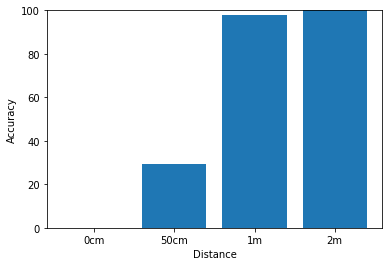

In [14]:
import matplotlib.pyplot as plt

_0cm = acc_0cm / len(res_0cm) * 100
_50cm = acc_50cm / len(res_50cm) * 100
_1m = acc_1m / len(res_1m) * 100
_2m = acc_2m / len(res_2m) * 100

x = np.arange(4)
testCase_num = ['0cm', '50cm', '1m', '2m']
values = [_0cm, _50cm, _1m, _2m]

plt.bar(x, values)
plt.xticks(x, testCase_num)
plt.ylim([0, 100])
plt.xlabel('Distance')
plt.ylabel('Accuracy')

plt.show()